<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-3)" data-toc-modified-id="Общее-впечатление-(ревью-3)-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 3)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем библиотеки,посмотрим общие сведения по данным

In [79]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import catboost as cb
from numpy.random import RandomState

from sklearn.metrics import mean_squared_error,make_scorer

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [113]:
taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',index_col=[0],parse_dates=[0])

In [114]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [82]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные предоставлены с интервалом в 10 минут

In [83]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Довольно большой разброс значений между минимальными и максимальными,что вполне возможно,учитыва что бывают пиковые нагрузки в аэропорту и нагрузка ночью на службу такси гораздо ниже.

In [115]:
taxi.sort_index(inplace=True)

In [85]:
print(taxi.index[0])
print(taxi.index[-1])

2018-03-01 00:00:00
2018-08-31 23:50:00


Данные предоставлены за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00,проверим их на монотонность

In [116]:
print(taxi.index.is_monotonic)

True


## Анализ

Построим график количества вызовов

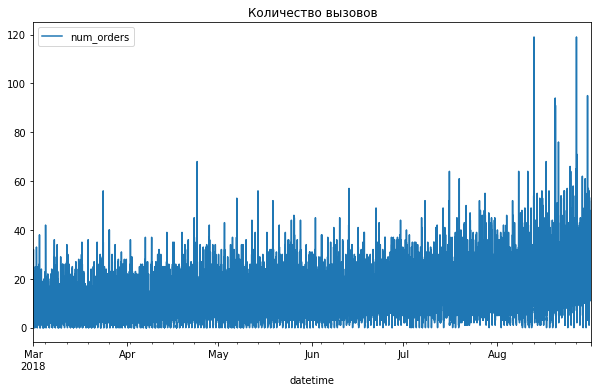

In [87]:
plt.figure(figsize=(10, 20))
plt.subplot(311)
taxi.plot(ax=plt.gca())
plt.title('Количество вызовов');

Получилось не слишком информативно,видно только,что в августе пиковых нагрузок в среднем больше,чем в начале весны. Это связано с сезоном отпусков. Попробуем сделать ресемплирование по часу.

In [117]:
taxi = taxi.resample('1H').sum()

In [89]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


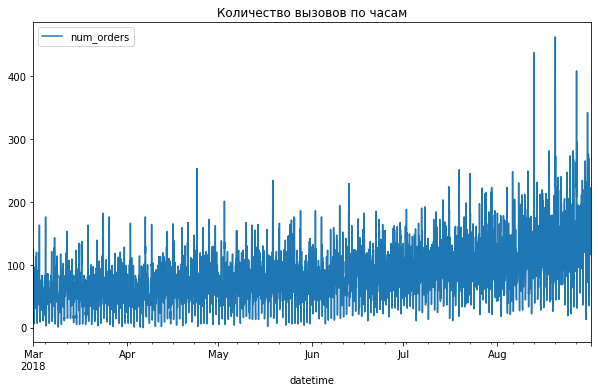

In [90]:
plt.figure(figsize=(10, 20))
plt.subplot(311)
taxi.plot(ax=plt.gca())
plt.title('Количество вызовов по часам');

Посмотрим выбросы

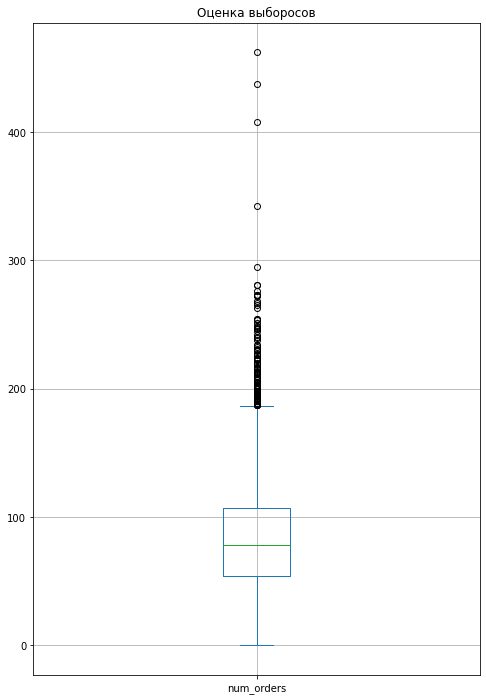

In [91]:
ax = taxi['num_orders'].plot(kind='box',grid= True,figsize=(8,12),title=('Оценка выборосов'))

Выбросы есть,верхняя квантиль находится в районе 32 такси,однако встречаются и значения выше нее,например 80. Данные мы удалять не можем,так как ряд должен быть непрерывным. Это будет несколько ухудшать модель предсказания,увеличивая RMSE,но критически не скажется.

Построим так же графики скользящего среднего, тренда и сезонности

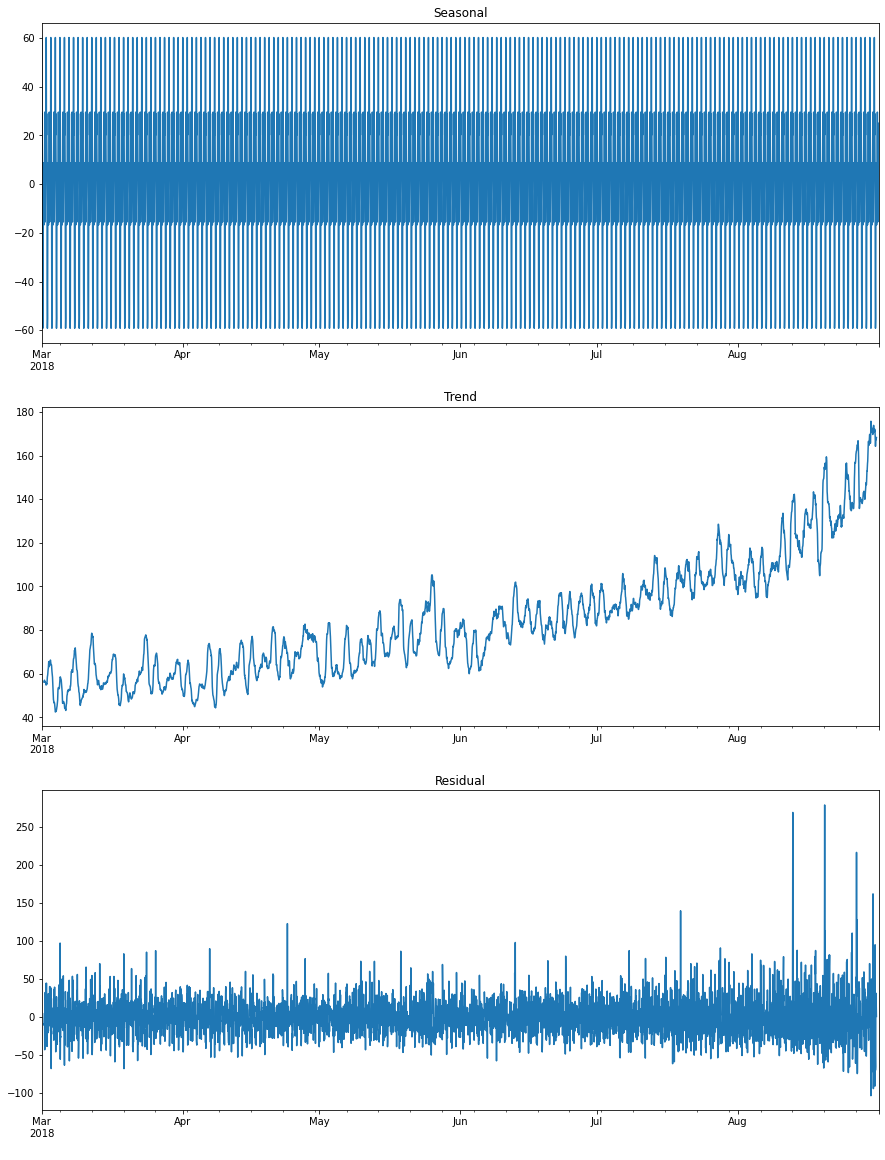

In [126]:
decomposed = seasonal_decompose(taxi)


plt.figure(figsize=(15, 20))

plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel(' ')
plt.title('Seasonal')

plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel(' ')
plt.title('Trend')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel(' ')
plt.title('Residual');

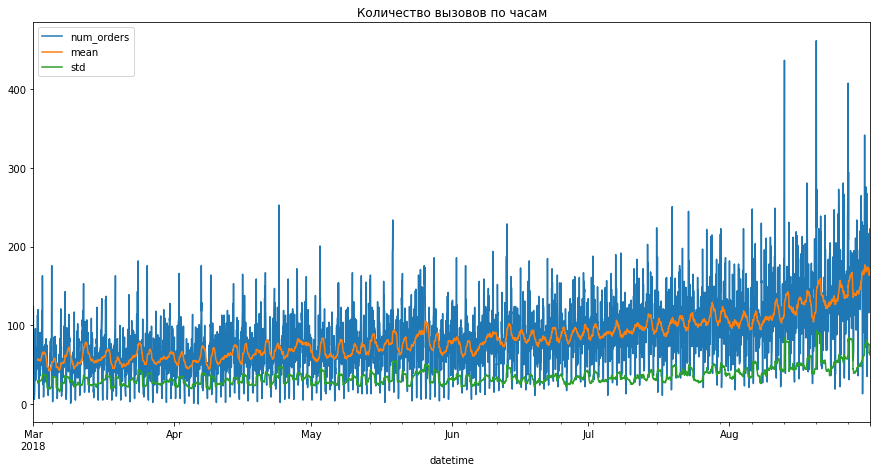

In [93]:
plt.figure(figsize=(15, 25))
plt.subplot(311)
taxi['mean'] = taxi['num_orders'].rolling(24).mean()
taxi['std'] = taxi['num_orders'].rolling(24).std()
plt.title('Количество вызовов по часам')
taxi.plot(ax=plt.gca());

Так и есть,к концу лета количество такси увеличвается относительно весенних месяцев

> Как мы видим,линия тренда идёт на увеличение,как и линия скользящего среднего.
По неполному набору (представлен только один сезон)нельзя адекватно оценивать сезонность,так как в данной масштабе сезонной не видна явно. Есть увеличения в марте,мае и ближе к августу,но по графику такого вида,учитывая высокие остатки от деления в предпоследнем графике я бы судить не стал.

Попробуем сделать сезонную декомпозицию по более узкому интервалу

Text(0.5, 1.0, 'Trend')

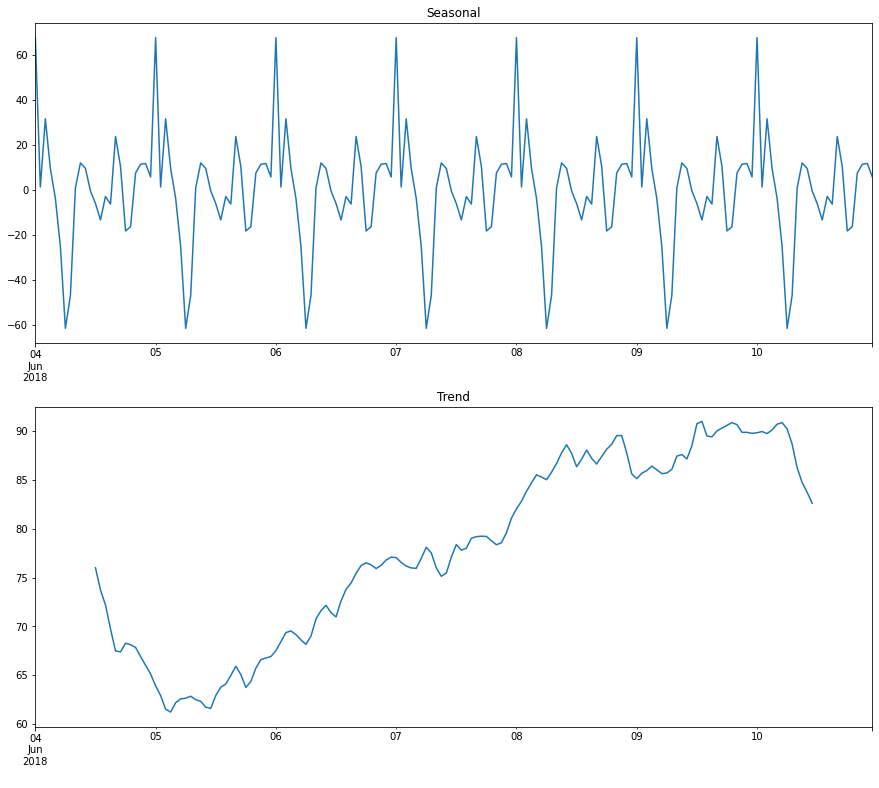

In [129]:
taxi_week = taxi['2018-06-04':'2018-06-10']
decomposed = seasonal_decompose(taxi_week)


plt.figure(figsize=(15, 20))

plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel(' ')
plt.title('Seasonal')

plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel(' ')
plt.title('Trend')


Сезонности здесь тоже не видно,однако линия тренда говорит нам о том,что к выходным колиечство заказов такси увеличивается.

Text(0.5, 1.0, 'Trend')

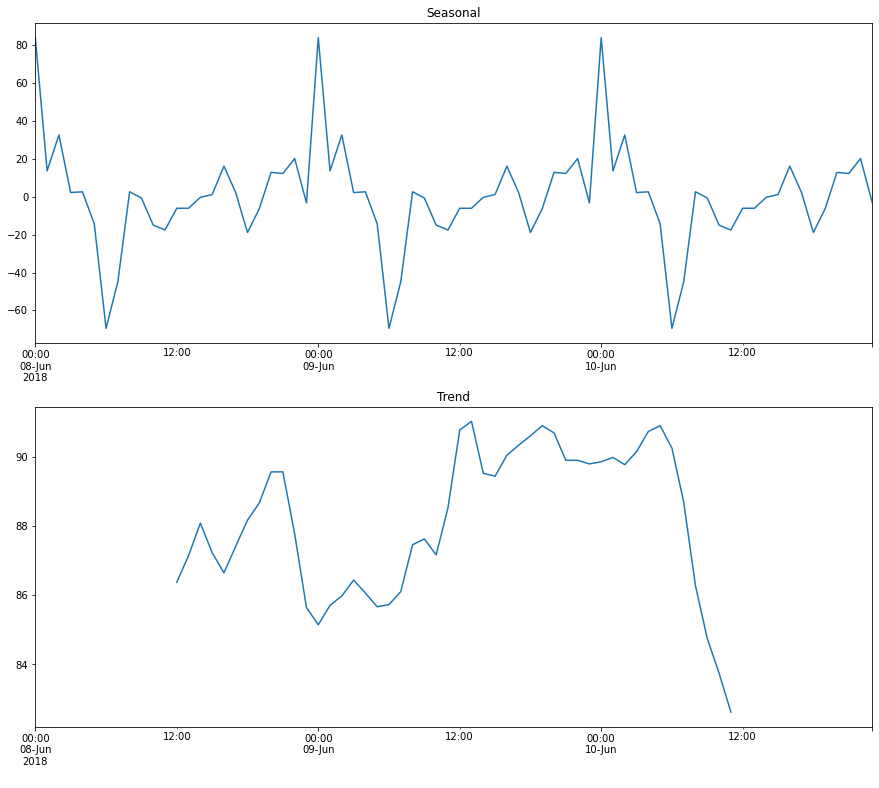

In [133]:
taxi_day = taxi['2018-06-08':'2018-06-10']
decomposed = seasonal_decompose(taxi_day)


plt.figure(figsize=(15, 20))

plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel(' ')
plt.title('Seasonal')

plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel(' ')
plt.title('Trend')

На данных графиках прослеживаются следующие закономерности:
- Наблюдаются пики на ночные вызовы такси в течение трех дней. Скорее всего это связано с тем, что возможность добраться домой общественным траспортом значительно снижена ночью и проще заказать такси;
- Минимальное количество вызовов такси приходится на ранее утро - 6 часов утра. Это может быть связано во-первых с меньшим количеством рейсов,которые в это время прилетают в аэропорт,а,во-вторых,с возможностью добраться до дома или работы на общественном траснпорте,избежав утренних пробок по пути.
- В субботу и воскресенье вызовов такси больше,к утру воскресенья и понедельнику нагрузка на такси снижается.

Создадим дополнительные признаки

In [94]:
def make_features(taxi, max_lag, rolling_mean_size):
    taxi['year'] = taxi.index.year
    taxi['month'] = taxi.index.month
    taxi['day'] = taxi.index.day
    taxi['day_of_week'] = taxi.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)
    taxi['rolling_mean'] = taxi['num_orders'].shift(1)
    taxi['rolling_mean'] = taxi['rolling_mean'].rolling(rolling_mean_size).mean()
    return taxi

In [95]:
taxi.head()

,num_orders,mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN


In [96]:
make_features(taxi,12,21)

,num_orders,mean,std,year,month,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,167.541667,63.268908,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,168.809524
2018-08-31 20:00:00,154,168.041667,63.105487,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,167.761905
2018-08-31 21:00:00,159,166.416667,62.801908,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,163.380952


Так же разделим выборки на обучающую и тестовую. В задании сказано оставить 10 процентов на тестовую выборку для проверки модели,так и сделаем.

In [97]:
train,test=train_test_split(taxi,shuffle=False,test_size=.1)
train = train.dropna()

features_train = train.drop('num_orders',axis=1)
features_test = test.drop('num_orders',axis=1)

target_train = train['num_orders']
target_test = test['num_orders']

Посмотрим размеры выборок

In [98]:
print('Обучающие признаки: ',features_train.shape, '/',target_train.shape)
print('Тестовые признаки: ',features_test.shape, '/',target_test.shape)

Обучающие признаки:  (3951, 19) / (3951,)
Тестовые признаки:  (442, 19) / (442,)


Выборки разделены нормально

## Обучение

Так же для кросс-валидации выборки с непрерывным временным рядом требуетcя другой вид деления,**TimeSeriesSplit**

In [99]:
tss_cv = TimeSeriesSplit(n_splits=5)

Напишем функцию для расчёта **RMSE**

In [100]:
def rmse(actual, predict):
    score = mean_squared_error(actual,predict)**0.5
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [101]:
model = LinearRegression()
rmse=[]
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
gs = GridSearchCV(estimator=model, cv=TimeSeriesSplit(n_splits=4).split(features_train),scoring=rmse_score,param_grid = parameters)

gs.fit(features_train, target_train)

print('RMSE train: ',-gs.best_score_)

RMSE train:  23.52656199352269
RMSE Test:  36.23899568085704


In [102]:
train =cb.Pool(features_train,target_train)
test =cb.Pool(features_test,target_test)

In [103]:
model_cbr = CatBoostRegressor(loss_function='RMSE',iterations=200)
grid = {'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model_cbr.grid_search(grid,train,shuffle=False,cv= tss_cv,refit=True)
#pred = model_cbr.predict(features_test)
#rmse = (np.sqrt(mean_squared_error(target_test, pred)))
print('Testing performance')
print('rmse grid',model_cbr.get_best_score())
print('Params: ',model_cbr.get_params())

0:	learn: 77.1702938	test: 112.4156147	best: 112.4156147 (0)	total: 1.27ms	remaining: 252ms
1:	learn: 75.2706933	test: 110.1886084	best: 110.1886084 (1)	total: 2.27ms	remaining: 225ms
2:	learn: 73.4489444	test: 108.1939907	best: 108.1939907 (2)	total: 3.03ms	remaining: 199ms
3:	learn: 71.6555185	test: 106.0282981	best: 106.0282981 (3)	total: 4.17ms	remaining: 205ms
4:	learn: 69.9214986	test: 103.9687392	best: 103.9687392 (4)	total: 5.3ms	remaining: 207ms
5:	learn: 68.2240323	test: 102.0305828	best: 102.0305828 (5)	total: 6.31ms	remaining: 204ms
6:	learn: 66.5880342	test: 100.1293730	best: 100.1293730 (6)	total: 7.13ms	remaining: 197ms
7:	learn: 65.0456987	test: 98.2609667	best: 98.2609667 (7)	total: 7.87ms	remaining: 189ms
8:	learn: 63.5163133	test: 96.4882196	best: 96.4882196 (8)	total: 8.69ms	remaining: 184ms
9:	learn: 62.1132241	test: 94.7380737	best: 94.7380737 (9)	total: 9.78ms	remaining: 186ms
10:	learn: 60.7341693	test: 93.1180565	best: 93.1180565 (10)	total: 10.6ms	remaining: 1

In [104]:
%%time
lgbm=LGBMRegressor()
grid={'max_depth':range(10,51,10),
      'n_estimators':range(10,101,10),
      'learning_rate':[0.02,0.04,1]}
lgbm_grid = GridSearchCV(estimator =lgbm, cv=TimeSeriesSplit(n_splits=4).split(features_train),
                    scoring=rmse_score,param_grid = grid,n_jobs=-1)
lgbm_grid.fit(features_train, target_train)
#predictions = lgbm_grid.predict(features_test)
#rmse.append(mean_squared_error(target_test,predictions))
print('RMSE : ',lgbm_grid.best_score_)
print('Params:',lgbm_grid.best_params_)

RMSE :  -29.253574858056645
Params: {'learning_rate': 0.04, 'max_depth': 20, 'n_estimators': 100}
Wall time: 8.69 s


### Выводы

Лучше всех показала себя модель ***CatBoostRegressor**:
- **RMSE**: 20.2333
- 'iterations': 200, 
- loss_function': 'RMSE'
- 'depth': 4,
-  'l2_leaf_reg': 1, 
- 'learning_rate': 0.1

Несколько хуже **LinearRegression**:
- **RMSE**:  23.5265

Хуже всего показала себя **LGBMRegressor**:
- **RMSE**: 29.25357
- 'learning_rate': 0.04, 
- 'max_depth': 20, 
- 'n_estimators': 100
Таким оразом,для тестовой выборки восполььзуемся **CatBoostRegressor** и  **LinearRegression**.

## Тестирование

Попробуем **CatBoostRegressor**

In [105]:
pred = model_cbr.predict(features_test)
rmse = (np.sqrt(mean_squared_error(target_test, pred)))
print('RMSE на тестовой выборке: ',rmse)

RMSE на тестовой выборке:  51.88191220950555


Результат на тестовой выборке сильно ухудшился,попробуем тогда **LinearRegression**

In [107]:
predictions_linear = gs.predict(features_test)
rmse_linear = (np.sqrt(mean_squared_error(target_test, predictions_linear)))

print('RMSE Test: ', rmse_linear)

RMSE Test:  36.23899568085704


Таким образом,получили значение **RMSE** равное **36.23899**, что удовлетворяет условию задания. Посмотрим так же распределение на графике.

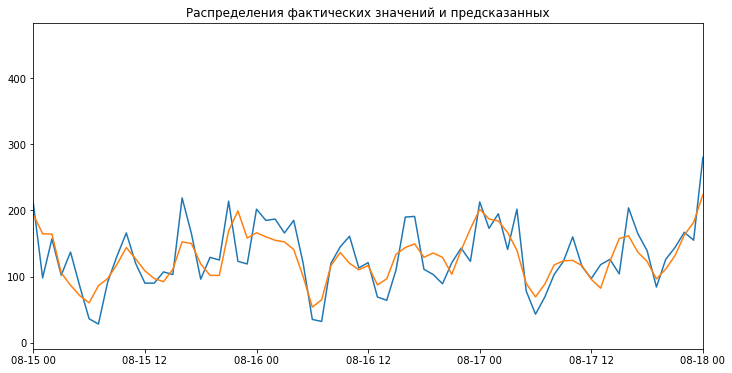

In [109]:
plt.figure(figsize=(12, 6))
plt.plot(target_test.index,target_test)
plt.plot(target_test.index, predictions_linear)
plt.xlim(pd.Timestamp('2018-08-15'), pd.Timestamp('2018-08-18'))
plt.title('Распределения фактических значений и предсказанных');

Распределения практически идентичны, значит всё сделано верно